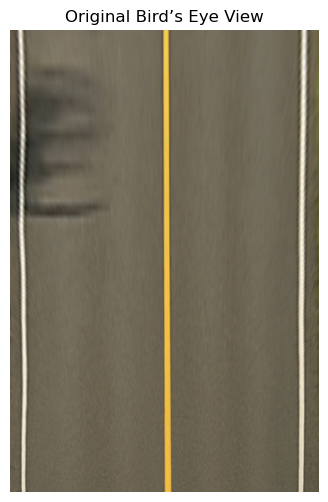

In [1]:
# ============================================================
# Step 0: Setup
# ============================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

# Load the Bird’s Eye View image (the top-down one)
img_path = "./init_photo.png"  # update path if needed
bev = cv2.imread(img_path)

# Display the original BEV
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(bev, cv2.COLOR_BGR2RGB))
plt.title("Original Bird’s Eye View")
plt.axis("off")
plt.show()


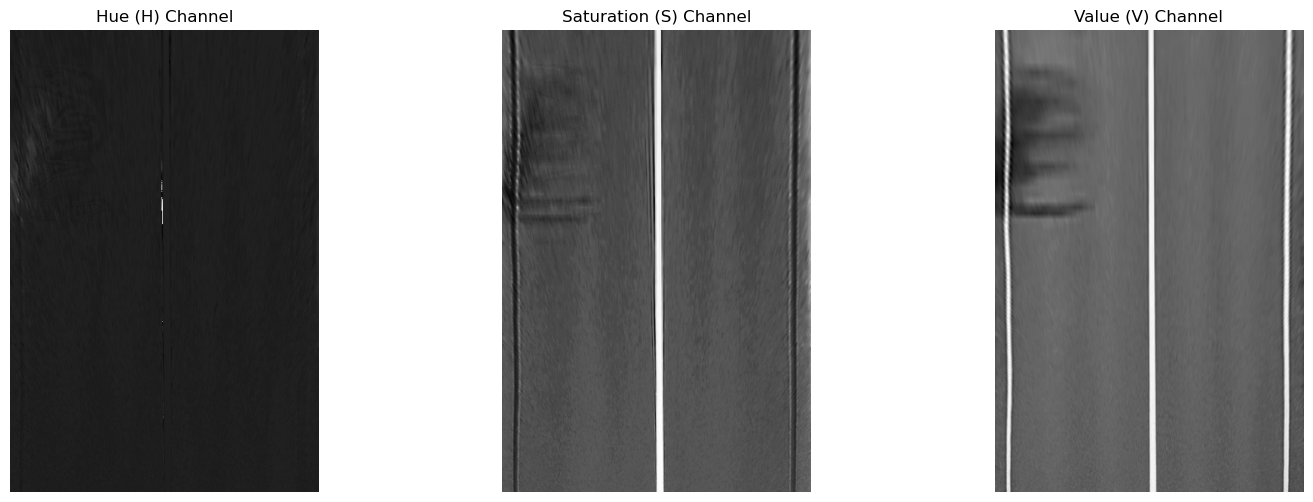

In [2]:
# ============================================================
# Step 1: Convert BGR → HSV and visualize each channel
# ============================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read BEV image
bev = cv2.imread("./init_photo.png")  # update if needed
hsv = cv2.cvtColor(bev, cv2.COLOR_BGR2HSV)

# Split into individual channels
H, S, V = cv2.split(hsv)

# Visualize all three channels
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(H, cmap='gray')
axs[0].set_title("Hue (H) Channel")
axs[0].axis("off")

axs[1].imshow(S, cmap='gray')
axs[1].set_title("Saturation (S) Channel")
axs[1].axis("off")

axs[2].imshow(V, cmap='gray')
axs[2].set_title("Value (V) Channel")
axs[2].axis("off")

plt.show()


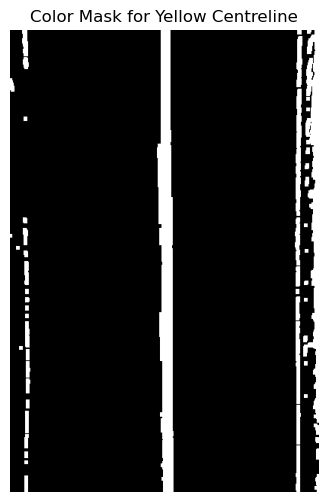

In [3]:
# ============================================================
# Step 2: Color Mask
# ============================================================
# Define HSV range for yellow (tune if needed)
lower_yellow = np.array([15, 80, 80])
upper_yellow = np.array([40, 255, 255])

color_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)

# Fill small gaps
kernel = np.ones((5, 5), np.uint8)
color_mask = cv2.dilate(color_mask, kernel, iterations=1)

plt.figure(figsize=(8, 6))
plt.imshow(color_mask, cmap='gray')
plt.title("Color Mask for Yellow Centreline")
plt.axis("off")
plt.show()


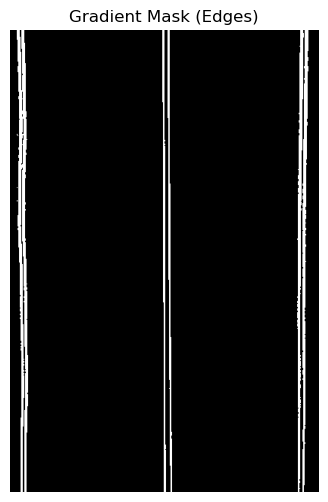

In [4]:
# ============================================================
# Step 3: Gradient Mask
# ============================================================
gray = cv2.cvtColor(bev, cv2.COLOR_BGR2GRAY)

# Compute Sobel gradients
grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
grad_mag = cv2.magnitude(grad_x, grad_y)

# Normalize and convert to uint8
grad_mag = np.uint8(255 * grad_mag / np.max(grad_mag))

# Threshold for strong gradients
t_min, t_max = 50, 255
gradient_mask = cv2.inRange(grad_mag, t_min, t_max)

plt.figure(figsize=(8, 6))
plt.imshow(gradient_mask, cmap='gray')
plt.title("Gradient Mask (Edges)")
plt.axis("off")
plt.show()


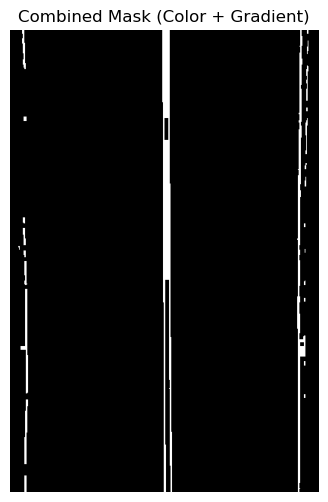

In [5]:
# ============================================================
# Step 4: Combine Masks
# ============================================================
combined_mask = cv2.bitwise_and(color_mask, gradient_mask)

# Optional morphology to refine
combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(8, 6))
plt.imshow(combined_mask, cmap='gray')
plt.title("Combined Mask (Color + Gradient)")
plt.axis("off")
plt.show()


Collected 153 points for polynomial fitting.


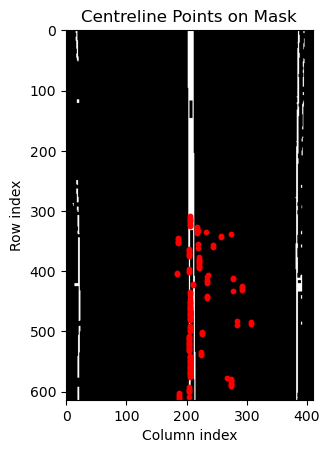

In [18]:
# ============================================================
# Step 5: Find Centreline points (rows, cols)
# ============================================================

import numpy as np
import cv2

# mask_combined = result from Step 4 (binary mask of the centreline)
height, width = combined_mask.shape

rows = []
cols = []

# Parameters
stride = 2       # process every 2nd row to speed up
tE = 2          # minimum number of white pixels required to consider the row valid

for r in range(height - 1, height // 2, -stride):  # from bottom → middle
    white_pixels = np.where(combined_mask[r, :] > 0)[0]  # indices of white pixels in row
    
    if len(white_pixels) > tE:
        c = np.mean(white_pixels)   # average column index
        rows.append(r)
        cols.append(c)

rows = np.array(rows)
cols = np.array(cols)

print(f"Collected {len(rows)} points for polynomial fitting.")

# Plot the binary mask
plt.imshow(combined_mask, cmap='gray')
plt.scatter(cols, rows, color='red', s=10)  # overlay centreline points
# plt.gca().invert_yaxis()  # optional: invert y-axis to match image coordinates
plt.title("Centreline Points on Mask")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()
# plt.figure(figsize=(8, 6))
# plt.imshow(combined_mask, cmap='gray')
# if len(rows) > 0:
#     plt.scatter(cols[0], rows[1], c='r', s=10)
# plt.title("Detected Centreline Points (Adaptive)")
# plt.axis("off")
# plt.show()

In [13]:
# ============================================================
# Step 6: Model Centreline — Fit 2nd-order polynomial (MSE)
# ============================================================

import numpy as np

# Assume we have the set of points (r, c) describing the centreline
# e.g. from Step 5
#   rows = np.array([...])   # y-coordinates (vertical positions)
#   cols = np.array([...])   # x-coordinates (average white-pixel positions)

# --- 1) Build design matrix for quadratic model: c = c2*r^2 + c1*r + c0 ---
A = np.vstack([rows**2, rows, np.ones_like(rows)]).T   # shape (N, 3)

# --- 2) Solve least squares problem: minimize ||A*[c2, c1, c0]^T - cols||^2 ---
coeffs, residuals, _, _ = np.linalg.lstsq(A, cols, rcond=None)
c2, c1, c0 = coeffs

# --- 3) Define model function for prediction ---
def poly(r):
    """Return column index (c) for a given row (r) using fitted polynomial."""
    return c2 * r**2 + c1 * r + c0

# --- 4) Optional: Compute MSE for quality check ---
pred_cols = poly(rows)
mse = np.mean((pred_cols - cols) ** 2)
print(f"Fitted coefficients: c2={c2:.6f}, c1={c1:.6f}, c0={c0:.2f}, MSE={mse:.4f}")


Fitted coefficients: c2=-0.000506, c1=0.464307, c0=116.20, MSE=750.4364


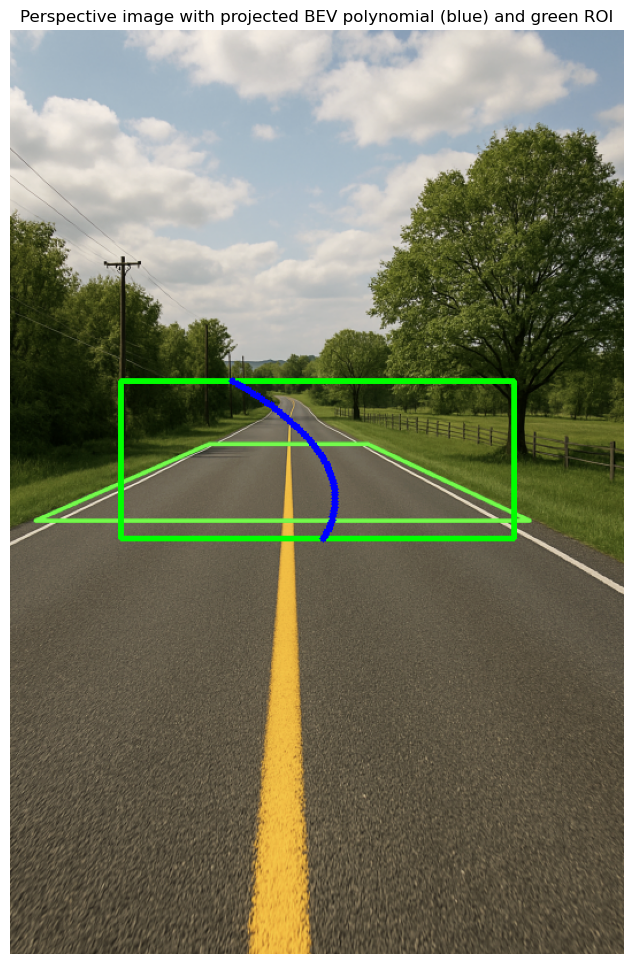

In [14]:
# ============================================================
# Step 7: Project BEV polynomial back to original perspective
# ============================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Paths (update if different) ---
persp_path = "./sector.png"   # perspective w/ green ROI
bev_path   = "./init_photo.png"   # bird's-eye view

# Load images
persp = cv2.imread(persp_path)            # BGR
bev   = cv2.imread(bev_path)              # BGR
h_bev, w_bev = bev.shape[:2]
h_p, w_p = persp.shape[:2]

# ---------- 1) Find the green ROI quadrilateral in the perspective image ----------
# convert to HSV and mask green (same green used to draw ROI)
hsv_p = cv2.cvtColor(persp, cv2.COLOR_BGR2HSV)

# These thresholds select bright neon-green used in the ROI.
# Tweak if your ROI green differs slightly.
lower_green = np.array([40, 200, 100])
upper_green = np.array([90, 255, 255])
mask_green = cv2.inRange(hsv_p, lower_green, upper_green)

# Morphology to clean mask
kernel = np.ones((5,5), np.uint8)
mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_green = cv2.dilate(mask_green, kernel, iterations=1)

# find contours and the largest polygon
contours, _ = cv2.findContours(mask_green, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

src_quad = None
if contours:
    # pick the largest contour by area
    c = max(contours, key=cv2.contourArea)
    # approximate polygonal curve
    eps = 0.02 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, eps, True)

    # If approx has 4 points, treat as quadrilateral ROI
    if len(approx) == 4:
        src_quad = approx.reshape(4, 2)
    else:
        # fallback: use bounding rect corners (still usable)
        x,y,w,h = cv2.boundingRect(c)
        src_quad = np.array([[x,y],[x+w,y],[x+w,y+h],[x,y+h]], dtype=np.float32)

else:
    # If no green contour found, *fallback* to manual guess of ROI rectangle in perspective:
    # This is a reasonable default for the image you showed, but update if not accurate.
    print("Warning: green ROI not found. Using fallback ROI coordinates.")
    margin_x = int(0.18 * w_p)
    top_y = int(0.38 * h_p)
    bot_y = int(0.55 * h_p)
    src_quad = np.array([
        [margin_x, top_y],
        [w_p - margin_x, top_y],
        [w_p - margin_x, bot_y],
        [margin_x, bot_y]
    ], dtype=np.float32)

# Order the src_quad points consistently: top-left, top-right, bottom-right, bottom-left
# helper to order points
def order_quad(pts):
    # pts: (4,2)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).reshape(-1)
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]
    return np.array([tl, tr, br, bl], dtype=np.float32)

src_quad_ordered = order_quad(np.array(src_quad, dtype=np.float32))

# Destination quad in BEV coordinates: full BEV image corners
dst_quad = np.array([
    [0, 0],
    [w_bev - 1, 0],
    [w_bev - 1, h_bev - 1],
    [0, h_bev - 1]
], dtype=np.float32)

# ---------- 2) Compute homographies ----------
# H_p2bev maps perspective ROI -> BEV image
H_p2bev = cv2.getPerspectiveTransform(src_quad_ordered, dst_quad)
# inverse homography: BEV -> perspective (we will use this)
H_bev2p = cv2.getPerspectiveTransform(dst_quad, src_quad_ordered)

# ---------- 3) Sample polynomial in BEV coordinates ----------
# Ensure poly exists. We expect poly(y) -> x in BEV coordinates from previous step.
# We will evaluate across BEV y coordinates (rows) — you can choose a subset or all rows.

# Safety: make sure 'poly' exists in scope. If not, attempt to fit from 'points' used earlier.
try:
    # If poly is numpy.poly1d, poly(y) returns x
    y_vals_bev = np.arange(0, h_bev, 1).astype(np.float32)
    x_vals_bev = poly(y_vals_bev)         # poly should be fitted as: x = poly(y)
except Exception as e:
    raise RuntimeError("Polynomial `poly` not found or invalid. Make sure Step 6 fitted `poly` as x = poly(y).") from e

# Keep only valid x inside BEV image bounds
valid_idx = np.where((x_vals_bev >= 0) & (x_vals_bev < w_bev))[0]
if len(valid_idx) == 0:
    raise RuntimeError("No valid polynomial points inside BEV bounds. Check polynomial fit or BEV size.")

# Create points in shape required by cv2.perspectiveTransform: (N,1,2) float32
bev_pts = np.stack([x_vals_bev[valid_idx], y_vals_bev[valid_idx]], axis=1).astype(np.float32)
bev_pts = bev_pts.reshape(-1, 1, 2)

# ---------- 4) Transform BEV points to perspective ----------
persp_pts = cv2.perspectiveTransform(bev_pts, H_bev2p)   # shape (N,1,2)
persp_pts = persp_pts.reshape(-1, 2)
persp_pts_int = np.round(persp_pts).astype(int)

# ---------- 5) Draw the projected centreline on the perspective image ----------
vis = persp.copy()

# draw the green ROI contour for reference (thick)
cv2.polylines(vis, [src_quad_ordered.astype(int)], isClosed=True, color=(0,255,0), thickness=3)

# draw blue centreline (polynomial) as a polyline
if len(persp_pts_int) > 1:
    # Clip pts to image bounds to avoid errors
    clipped = []
    for x,y in persp_pts_int:
        x_c = int(np.clip(x, 0, w_p-1))
        y_c = int(np.clip(y, 0, h_p-1))
        clipped.append((x_c,y_c))
    cv2.polylines(vis, [np.array(clipped, dtype=np.int32)], isClosed=False, color=(255,0,0), thickness=4)

# optionally draw small circles at sample points
for (x,y) in persp_pts_int[::max(1, len(persp_pts_int)//50)]:  # draw up to ~50 points
    cv2.circle(vis, (int(x),int(y)), radius=3, color=(255,0,0), thickness=-1)

# Show result (convert BGR->RGB for matplotlib)
plt.figure(figsize=(8,12))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Perspective image with projected BEV polynomial (blue) and green ROI")
plt.axis("off")
plt.show()
